In [1]:
%pylab inline
import cv2
import glob

Populating the interactive namespace from numpy and matplotlib


In [2]:
nb_vertical = 6
nb_horizontal = 9

objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32)
objp[:,:2] = np.mgrid[0:nb_vertical,0:nb_horizontal].T.reshape(-1,2)

objpoints_left = [] # 3d point in real world space
imgpoints_left = [] # 2d points in image plane.

lefts = glob.glob('Stereo_calibration_images/left*.png')
assert lefts

for fname in lefts:
    img = cv2.imread(fname)
    h, w = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(img, (nb_vertical,nb_horizontal),  None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints_left.append(objp)

        imgpoints_left.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nb_vertical,nb_horizontal), corners,ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(50)

#cv2.destroyAllWindows()
#cv2.waitKey(1)


objpoints_right = [] # 3d point in real world space
imgpoints_right = [] # 2d points in image plane.

rights = glob.glob('Stereo_calibration_images/right*.png')
assert rights


for fname in rights:
    img = cv2.imread(fname)
    h, w = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(img, (nb_vertical,nb_horizontal),  None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints_right.append(objp)

        imgpoints_right.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nb_vertical,nb_horizontal), corners,ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(50)

#cv2.destroyAllWindows()
#cv2.waitKey(1)

In [3]:
ret_left, mtx_left, dist_left, rvecs_left, tvecs_left = cv2.calibrateCamera(objpoints_left, imgpoints_left, gray.shape[::-1], None, None)
img_left = cv2.imread('Stereo_calibration_images/left-0000.png')
h_left,  w_left = img_left.shape[:2]
newcameramtx_left, roi_left = cv2.getOptimalNewCameraMatrix(mtx_left,dist_left,(w_left,h_left),1,(w_left,h_left))
print (newcameramtx_left,roi_left)
ret_right, mtx_right, dist_right, rvecs_right, tvecs_right = cv2.calibrateCamera(objpoints_right, imgpoints_right, gray.shape[::-1], None, None)
img_right = cv2.imread('Stereo_calibration_images/right-0000.png')
h_right,  w_right = img_right.shape[:2]
newcameramtx_right, roi_right = cv2.getOptimalNewCameraMatrix(mtx_right,dist_right,(w_right,h_right),1,(w_right,h_right))
print (newcameramtx_right,roi_right)

[[112.28690338   0.         982.05689904]
 [  0.         111.80508423 582.24763194]
 [  0.           0.           1.        ]] (844, 523, 243, 115)
[[4.12920609e+01 0.00000000e+00 1.20742963e+03]
 [0.00000000e+00 5.25937042e+01 6.71338991e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] (1169, 643, 76, 54)


Text(0.5, 1.0, 'Undistorted right image')

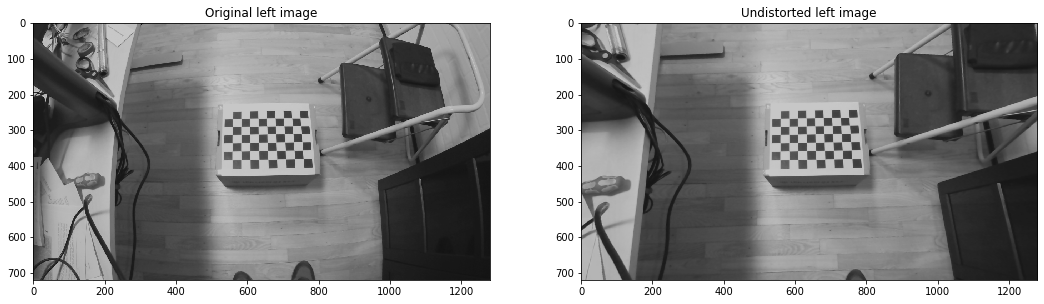

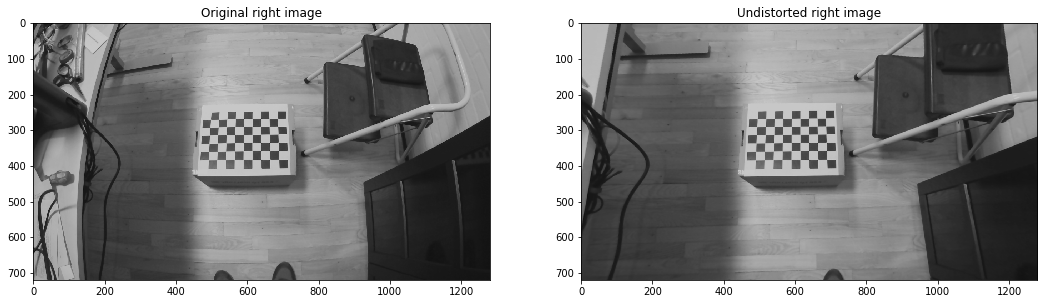

In [4]:
# undistort
dst_left = cv2.undistort(img_left, mtx_left, dist_left, None, None)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax[0].imshow(img_left[...,[2,1,0]])
ax[0].set_title('Original left image')
ax[1].imshow(dst_left[...,[2,1,0]])
ax[1].set_title('Undistorted left image')

# undistort
dst_right = cv2.undistort(img_right, mtx_right, dist_right, None, None)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax[0].imshow(img_right[...,[2,1,0]])
ax[0].set_title('Original right image')
ax[1].imshow(dst_right[...,[2,1,0]])
ax[1].set_title('Undistorted right image')

In [6]:
# ------------------------------------------------------------
# STEREO RECTIFICATION

# Calculate the fundamental matrix for the cameras
# https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
flag = cv2.CALIB_FIX_ASPECT_RATIO
flag |= cv2.CALIB_ZERO_TANGENT_DIST

retval, mtx_left, dist_left, mtx_right, dist_right, R, T, E, F = cv2.stereoCalibrate(objpoints_left, 
                                                                                    imgpoints_left, 
                                                                                    imgpoints_right, 
                                                                                    mtx_left, dist_left, 
                                                                                    mtx_right, dist_right, 
                                                                                    (img_left.shape[1],
                                                                                     img_left.shape[0]),
                                                                                   flags=flag)

R1, R2, P1, P2, Q, validPixROI1, validPixROI2 = cv2.stereoRectify(mtx_left, dist_left,
                                                                mtx_right, dist_right, 
                                                                (img_left.shape[1],img_left.shape[0]), 
                                                                R, T, alpha = 0)

In [7]:
map1_left, map2_left = cv2.initUndistortRectifyMap(mtx_left, dist_left, R1, P1, (img_left.shape[1],img_left.shape[0]), cv2.CV_32FC1)
map1_right, map2_right = cv2.initUndistortRectifyMap(mtx_right, dist_right, R2, P2, (img_left.shape[1],img_left.shape[0]), cv2.CV_32FC1)

In [8]:
output_img_left = cv2.remap(dst_left, map1_left, map2_left, cv2.INTER_NEAREST)
output_img_right = cv2.remap(dst_right, map1_right, map2_right, cv2.INTER_NEAREST)

(0, 0, 1280, 720) (0, 0, 1280, 720)


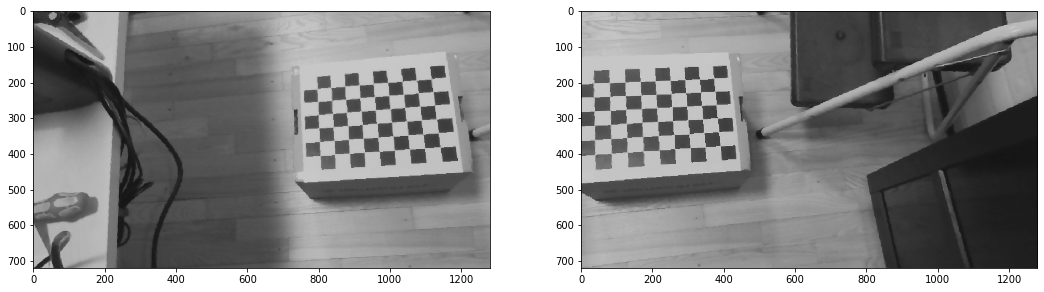

In [9]:
figure(figsize=(18,10))
subplot(121),imshow(output_img_left)
subplot(122),imshow(output_img_right)
print(validPixROI1,validPixROI2)

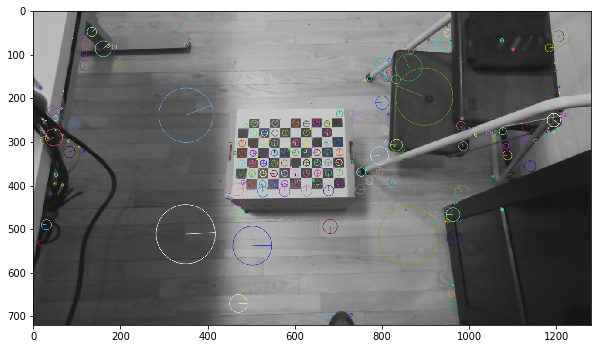

In [10]:
img1 = cv2.cvtColor(dst_left, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(dst_right, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

kp_img = cv2.drawKeypoints(img2, kp2, img2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize = (10,10))
plt.imshow(kp_img)

In [11]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Keep good matches: calculate distinctive image features
# Lowe, D.G. Distinctive Image Features from Scale-Invariant Keypoints. International Journal of Computer Vision 60, 91–110 (2004). https://doi.org/10.1023/B:VISI.0000029664.99615.94
# https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

In [12]:
# Stereo rectification (uncalibrated variant)
# Adapted from: https://stackoverflow.com/a/62607343
h1, w1 = img1.shape
h2, w2 = img2.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), F, imgSize=(w1, h1)
)

In [13]:
# Undistort (rectify) the images and save them
# Adapted from: https://stackoverflow.com/a/62607343
img1_rectified = cv2.warpPerspective(dst_left, H1, (w1, h1))
img2_rectified = cv2.warpPerspective(dst_left, H2, (w2, h2))

In [ ]:
gray1_rect = cv2.cvtColor(img1_rectified, cv2.COLOR_BGR2GRAY)
gray2_rect = cv2.cvtColor(img2_rectified, cv2.COLOR_BGR2GRAY)

In [ ]:
# Visualize epilines
# Adapted from: https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
def drawlines(img1src, img2src, lines, pts1src, pts2src):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    [r, c] = img1src.shape
    img1color = cv2.cvtColor(img1src, cv2.COLOR_GRAY2BGR)
    img2color = cv2.cvtColor(img2src, cv2.COLOR_GRAY2BGR)
    # Edit: use the same random seed so that two images are comparable!
    np.random.seed(0)
    for r, pt1, pt2 in zip(lines, pts1src, pts2src):
        try:
            color = tuple(np.random.randint(0, 255, 3).tolist())
            x0, y0 = map(int, [0, -r[2]/r[1]])
            x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
            img1color = cv2.line(img1color, (x0, y0), (x1, y1), color, 1)
            img1color = cv2.circle(img1color, tuple(pt1), 5, color, -1)
            img2color = cv2.circle(img2color, tuple(pt2), 5, color, -1)
        except TypeError:
            print(r, pt1, pt2)
    return img1color, img2color


# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(
    array(pts2).reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(gray1_rect, gray2_rect, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(
    array(pts1).reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(gray2_rect, gray1_rect, lines2, pts2, pts1)

plt.figure(figsize=(16,5))
plt.subplot(221), plt.imshow(img5)
plt.subplot(222), plt.imshow(img6)
plt.subplot(223), plt.imshow(img3)
plt.subplot(224), plt.imshow(img4)
plt.suptitle("Epilines in both images")
plt.show()

In [ ]:
# Draw the rectified images
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].imshow(img1_rectified, cmap="gray")
axes[1].imshow(img2_rectified, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.suptitle("Rectified images")

In [ ]:
# Draw the keypoint matches between both pictures
# Still based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask[300:500],
                   flags=cv2.DrawMatchesFlags_DEFAULT)

keypoint_matches = cv2.drawMatchesKnn(
    img1, kp1, img2, kp2, matches[300:500], None, **draw_params)
plt.imshow(keypoint_matches)

In [ ]:
def rectcropper(im):
    return im[50:630,120:]
img1_rect_crop = rectcropper(img1_rectified)
img2_rect_crop = rectcropper(img2_rectified)
plt.figure(figsize=(16,10))
plt.subplot(121)
plt.imshow(img1_rect_crop, cmap='gray')
plt.subplot(122)
plt.imshow(img2_rect_crop, cmap='gray')

In [ ]:
def pipeline(im_left, im_right):
    
    dst_left = cv2.undistort(im_left, mtx_left, dist_left, None, None)
    dst_right = cv2.undistort(im_right, mtx_right, dist_right, None, None)
    
    iml = cv2.cvtColor(dst_left, cv2.COLOR_BGR2GRAY)
    imr = cv2.cvtColor(dst_right, cv2.COLOR_BGR2GRAY)
    
    imlrectified = cv2.warpPerspective(iml, H1, (w1, h1))
    imrrectified = cv2.warpPerspective(imr, H2, (w2, h2))
    
    imlcrop = rectcropper(imlrectified)
    imrcrop = rectcropper(imrrectified)
    
    return imlcrop, imrcrop

def pipeleft(im, warp = True, crop = True):
    im = cv2.undistort(im, mtx_left, dist_left, None, None)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    if warp: im = cv2.warpPerspective(im, H1, (w1, h1))
    if crop: im = rectcropper(im)
    return im

def piperight(im, warp = True, crop = True):
    im = cv2.undistort(im, mtx_right, dist_right, None, None)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    if warp: im = cv2.warpPerspective(im, H2, (w2, h2))
    if crop: im = rectcropper(im)
    return im

In [ ]:
import os
from datetime import datetime

left_dir = os.listdir('Stereo_conveyor_without_occlusions/left/')
left_dir = [f.lower() for f in left_dir]   # Convert to lower case
left_dir = sorted(left_dir)

right_dir = os.listdir('Stereo_conveyor_without_occlusions/right/')
right_dir = [f.lower() for f in right_dir]   # Convert to lower case
right_dir = sorted(right_dir)

In [ ]:
now = datetime.now()

for fname in left_dir:
    img = cv2.imread('Stereo_conveyor_without_occlusions/left/' + fname)
    h, w = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imshow('img',gray)
    cv2.waitKey(1000//60)

cv2.destroyAllWindows()
cv2.waitKey(1)

print(datetime.now()-now)

In [ ]:
for fname in left_dir:
    img = cv2.imread('Stereo_conveyor_without_occlusions/left/' + fname)
    h, w = img.shape[:2]
    im = pipeleft(img, warp = False, crop = False)
    cv2.imshow('img',im)
    cv2.waitKey(1000//60)

cv2.destroyAllWindows()
cv2.waitKey(1)

In [ ]:
print('test')